In [62]:
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

data_path = '/Users/emmazhou/Desktop/UW-Emma/AMATH482/HW-1/subdata.npy'

d = np.load(data_path) # huge matrix of size 262144 x 49 (columns contain flattened 3d matrix of size 64x64x64)

In [63]:
N_grid = 64
L = 10
xx = np.linspace(-L, L, N_grid+1) #spatial grid in x dir
x = xx[0:N_grid]
y = x # same grid in y,z direction
z = x
sum_of_fhat = np.zeros((N_grid, N_grid, N_grid))
K_grid = (2*np.pi/(2*L))*np.linspace(-N_grid/2, N_grid/2 -1, N_grid)

for j in range(0,49):
    
    signal = np.reshape(d[:, j], (N_grid, N_grid, N_grid))
    fhat = np.fft.fftshift(np.fft.fftn(signal))
    sum_of_fhat =  sum_of_fhat + fhat
  
average_FT = sum_of_fhat/49  

magnitude_average_FT = np.abs(average_FT)
max_position = np.unravel_index(np.argmax(magnitude_average_FT), magnitude_average_FT.shape)
print("The frequency signature is",max_position)

The frequency signature is (39, 49, 10)


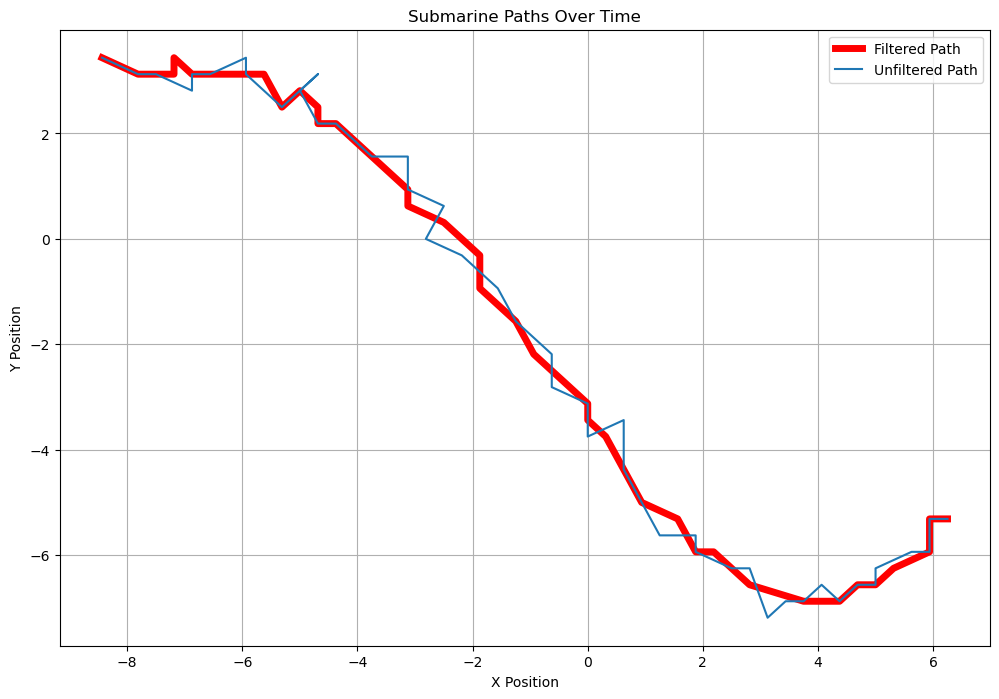

In [59]:
center_position = max_position

KX, KY, KZ= np.meshgrid(K_grid, K_grid, K_grid)

x_center_index = center_position[0]
y_center_index = center_position[1]
z_center_index = center_position[2]


def g_3d(KX, KY, KZ, s): # 3D Gaussian filter
   
    val = np.exp(-((KX-K_grid[x_center_index])**2 + (KY-K_grid[y_center_index])**2 + (KZ-K_grid[z_center_index])**2) / (2 * s**2))
    return val

sigma = 4.5
filter_ft = g_3d(KX, KY, KZ, sigma)

all_positions_index = []
all_unfiltered_positions_index = []

for j in range(0, 49):
    
    signal = np.reshape(d[:, j], (N_grid, N_grid, N_grid))
    fhat = np.fft.fftshift(np.fft.fftn(signal))
    filtered_fhat = fhat * filter_ft
    
    filtered_data = np.fft.ifftn(np.fft.ifftshift(filtered_fhat))
    unfiltered_data = np.fft.ifftn(np.fft.ifftshift(fhat))
    
    magnitude_filtered_FT = np.abs(filtered_data)
    magnitude_unfiltered_FT = np.abs(unfiltered_data)
    
    current_position_index = np.unravel_index(np.argmax(magnitude_filtered_FT), magnitude_filtered_FT.shape)
    unfiltered_position_index = np.unravel_index(np.argmax(magnitude_unfiltered_FT), magnitude_unfiltered_FT.shape)
    
    all_positions_index.append(current_position_index)
    all_unfiltered_positions_index.append(unfiltered_position_index)
    
all_positions_index = np.array(all_positions_index)
all_unfiltered_positions_index = np.array(all_unfiltered_positions_index)


# Extract x and y coordinates for each index
x_coordinates = x[all_positions_index[:, 0]]
y_coordinates = y[all_positions_index[:, 1]]
z_coordinates = z[all_positions_index[:, 2]]

x_unfil = x[all_unfiltered_positions_index[:, 0]]
y_unfil = y[all_unfiltered_positions_index[:, 1]]

fig_data = go.Scatter3d( x = x_coordinates, y = y_coordinates, z = z_coordinates, mode='markers',
                       marker=dict(size=3))
fig = go.Figure( data = [fig_data] )
fig.update_layout(title_text='Submarine Path in 3D')
fig.show()

#Plot the x and y values
plt.figure(figsize=(12, 8))

plt.plot(x_coordinates, y_coordinates, color = 'red', linewidth=5, label='Filtered Path')
plt.plot(x_unfil, y_unfil, label='Unfiltered Path')


plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Submarine Paths Over Time')
plt.legend()
plt.grid(True)
plt.show()